# Notebook 03 — Baseline-Modelle, Cross-Validation & Leakage-Check (Anforderungen 6–8)

**Input:** `data/processed/model_ready.csv` (aus Notebook 02)  
**Target:** `moving_time` (Sekunden)

Ziele:
- Aufbau eines reproduzierbaren Baseline-Setups für Regression (CV, Metriken, Vergleich)
- Modellvergleich einfacher Modelle (z. B. Dummy, Linear, Ridge)
- **Leakage-Experiment:** Vergleich **ohne** vs. **mit** `elapsed_time`

**Wichtige Abgrenzung:**
- Noch kein komplexes Feature Engineering; Fokus auf saubere Baselines und eine klare Evaluationslogik.
- Alle Ergebnisse (Tabellen/Plots) werden gespeichert (`data_derived/`, `plots/`).


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")


In [2]:
if not PATH_MODEL_READY.exists():
    raise FileNotFoundError(f"model_ready.csv not found at: {PATH_MODEL_READY}")

df = pd.read_csv(PATH_MODEL_READY)
print("Loaded model_ready:", df.shape)
display(df.head())

TARGET = "moving_time"

# Baseline feature set (no leakage)
FEATURES_BASE = [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
    "stop_ratio",  # optional quality feature; we keep it for now and can ablate later
]

# Leakage candidate feature set
FEATURES_WITH_ELAPSED = FEATURES_BASE + ["elapsed_time"]

# Safety: keep only existing columns
FEATURES_BASE = [c for c in FEATURES_BASE if c in df.columns]
FEATURES_WITH_ELAPSED = [c for c in FEATURES_WITH_ELAPSED if c in df.columns]

print("FEATURES_BASE:", FEATURES_BASE)
print("FEATURES_WITH_ELAPSED:", FEATURES_WITH_ELAPSED)


Loaded model_ready: (9039, 10)


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain,stop_time,stop_ratio,avg_speed_implied_kmh,pace_min_per_km
0,102977.0,15212,476.6,241.6,14505,968.0,707,0.046476,25.557890,2.347612
1,64046.5,10964,394.8,221.2,9097,768.0,1867,0.170285,25.345433,2.367290
2,38853.7,5271,68.4,-27.4,5271,162.0,0,0.000000,26.536392,2.261046
3,39075.8,6634,57.8,-28.2,4813,79.0,1821,0.274495,29.227692,2.052848
4,51232.3,7491,228.6,-10.2,7491,608.0,0,0.000000,24.621049,2.436939


FEATURES_BASE: ['distance', 'total_elevation_gain', 'highest_elevation', 'lowest_elevation', 'stop_ratio']
FEATURES_WITH_ELAPSED: ['distance', 'total_elevation_gain', 'highest_elevation', 'lowest_elevation', 'stop_ratio', 'elapsed_time']


## Cross-Validation Setup & Metriken

Wir evaluieren Modelle mit **K-Fold Cross-Validation** (reproduzierbar via `random_state`).

Metriken:
- **MAE** (Mean Absolute Error) — gut interpretierbar in Sekunden
- **RMSE** (Root Mean Squared Error) — bestraft große Fehler stärker
- **R²** — Anteil erklärter Varianz

Hinweis: Alle Modelle nutzen nur numerische Features. Fehlende Werte werden (falls vorhanden) imputiert.


In [4]:
from sklearn.preprocessing import PolynomialFeatures

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "r2": make_scorer(r2_score),
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

def eval_model(name: str, model: Pipeline, X: pd.DataFrame, y: pd.Series) -> dict:
    res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return {
        "model": name,
        "mae_mean": -res["test_mae"].mean(),
        "mae_std": res["test_mae"].std(),
        "rmse_mean": -res["test_rmse"].mean(),
        "rmse_std": res["test_rmse"].std(),
        "r2_mean": res["test_r2"].mean(),
        "r2_std": res["test_r2"].std(),
    }


In [8]:
from sklearn.preprocessing import PolynomialFeatures

X_base = df[FEATURES_BASE].copy()
y = df[TARGET].copy()

preprocess_num = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

models = []

# Dummy baseline
models.append((
    "Dummy (median)",
    Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", DummyRegressor(strategy="median"))
    ])
))

# Linear
models.append((
    "LinearRegression",
    Pipeline(steps=[
        ("prep", preprocess_num),
        ("model", LinearRegression())
    ])
))

# Ridge
models.append((
    "Ridge (alpha=1.0)",
    Pipeline(steps=[
        ("prep", preprocess_num),
        ("model", Ridge(alpha=1.0, random_state=SEED))
    ])
))

# Poly2 + Ridge
models.append((
    "Poly2 + Ridge (alpha=1.0)",
    Pipeline(steps=[
        ("prep", preprocess_num),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("model", Ridge(alpha=1.0, random_state=SEED))
    ])
))

# Poly3 + Ridge
models.append((
    "Poly3 + Ridge (alpha=1.0)",
    Pipeline(steps=[
        ("prep", preprocess_num),
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("model", Ridge(alpha=1.0, random_state=SEED))
    ])
))

# Poly4 + Ridge
models.append((
    "Poly4 + Ridge (alpha=1.0)",
    Pipeline(steps=[
        ("prep", preprocess_num),
        ("poly", PolynomialFeatures(degree=4, include_bias=False)),
        ("model", Ridge(alpha=1.0, random_state=SEED))
    ])
))

results_base = []
for name, pipe in models:
    results_base.append(eval_model(name, pipe, X_base, y))

results_base_df = pd.DataFrame(results_base).sort_values("mae_mean")
display(results_base_df)

results_base_df.to_csv(PATH_DERIVED / "21_cv_results_poly_degree_comparison_no_elapsed.csv", index=False)


,model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std
4,Poly3 + Ridge (alpha=1.0),620.541850,21.739762,1150.310547,82.086502,0.932632,0.007367
3,Poly2 + Ridge (alpha=1.0),641.157714,21.533531,1143.509608,47.205150,0.933485,0.003819
5,Poly4 + Ridge (alpha=1.0),677.105986,74.975628,2148.620742,876.101685,0.733962,0.179631
1,LinearRegression,721.477168,22.410319,1233.780599,47.076949,0.922546,0.004519
2,Ridge (alpha=1.0),721.491452,22.400493,1233.779996,47.069221,0.922547,0.004519
0,Dummy (median),3048.838062,94.144825,4852.255253,138.825887,-0.196792,0.014522


## Hyperparameter-Tuning: Ridge-Regularisierung (alpha)

Bisher wurde `alpha=1.0` als Default genutzt, um Modelle schnell vergleichbar zu machen.  
Für eine faire Modellauswahl wird `alpha` nun datengetrieben via Cross-Validation optimiert.

Getunt werden:
- Polynomial degree ∈ {2, 3}
- Ridge alpha ∈ logspace(-4, 4)

Optimierungsziel: **MAE minimieren** (interpretierbar in Sekunden).


In [9]:
from sklearn.model_selection import GridSearchCV

X = df[FEATURES_BASE].copy()
y = df[TARGET].copy()

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False, degree=2)),  # placeholder, tuned below
    ("ridge", Ridge(random_state=SEED)),
])

param_grid = {
    "poly__degree": [2, 3],
    "ridge__alpha": np.logspace(-4, 4, 9),
}

# Use MAE as optimization target (minimize)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)


Best params: {'poly__degree': 3, 'ridge__alpha': np.float64(10.0)}
Best CV MAE: 619.6394332676593


In [10]:
gs = pd.DataFrame(grid.cv_results_)

out = gs[[
    "param_poly__degree",
    "param_ridge__alpha",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]].copy()

out["mae_mean"] = -out["mean_test_score"]
out["mae_std"] = out["std_test_score"]
out = out.drop(columns=["mean_test_score", "std_test_score"]).sort_values(
    ["mae_mean", "mae_std"], ascending=[True, True]
)

display(out.head(20))

out.to_csv(PATH_DERIVED / "22_gridsearch_poly_ridge_no_elapsed.csv", index=False)


,param_poly__degree,param_ridge__alpha,rank_test_score,mae_mean,mae_std
14,3,10.0000,1,619.639433,20.945923
13,3,1.0000,2,620.541850,21.739762
12,3,0.1000,3,620.685582,21.837592
11,3,0.0100,4,620.700554,21.847451
10,3,0.0010,5,620.702054,21.848440
9,3,0.0001,6,620.702204,21.848539
15,3,100.0000,7,634.562733,20.042860
0,2,0.0001,8,641.105150,21.550552
1,2,0.0010,9,641.105196,21.550537
2,2,0.0100,10,641.105662,21.550388


## Leakage-Check: Modellvergleich mit `elapsed_time`

`elapsed_time` ist inhaltlich sehr nah an `moving_time` (Gesamtzeit inkl. Pause vs. Fahrzeit ohne Pause).  
Wir evaluieren daher das gleiche Modell-Setup zusätzlich **mit `elapsed_time`** als Feature.

Interpretation:
- Das Modell **mit** `elapsed_time` dient als **Upper Bound / Kontrollmodell**.
- Für ein realistisches Vorhersageszenario wird `elapsed_time` in der Regel **nicht** genutzt.


In [11]:
X_leak = df[FEATURES_WITH_ELAPSED].copy()
y = df[TARGET].copy()

pipe_leak = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False, degree=2)),
    ("ridge", Ridge(random_state=SEED)),
])

param_grid_leak = {
    "poly__degree": [2, 3],
    "ridge__alpha": np.logspace(-4, 4, 9),
}

grid_leak = GridSearchCV(
    estimator=pipe_leak,
    param_grid=param_grid_leak,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

grid_leak.fit(X_leak, y)

print("Best params (with elapsed_time):", grid_leak.best_params_)
print("Best CV MAE (with elapsed_time):", -grid_leak.best_score_)


Best params (with elapsed_time): {'poly__degree': 2, 'ridge__alpha': np.float64(0.0001)}
Best CV MAE (with elapsed_time): 0.00029133577915589815


In [12]:
gs_leak = pd.DataFrame(grid_leak.cv_results_)

out_leak = gs_leak[[
    "param_poly__degree",
    "param_ridge__alpha",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]].copy()

out_leak["mae_mean"] = -out_leak["mean_test_score"]
out_leak["mae_std"] = out_leak["std_test_score"]
out_leak = out_leak.drop(columns=["mean_test_score", "std_test_score"]).sort_values(
    ["mae_mean", "mae_std"], ascending=[True, True]
)

display(out_leak.head(20))

out_leak.to_csv(PATH_DERIVED / "23_gridsearch_poly_ridge_with_elapsed.csv", index=False)


,param_poly__degree,param_ridge__alpha,rank_test_score,mae_mean,mae_std
0,2,0.0001,1,0.000291,0.000010
9,3,0.0001,2,0.000458,0.000018
1,2,0.0010,3,0.002913,0.000101
10,3,0.0010,4,0.004583,0.000180
2,2,0.0100,5,0.029131,0.001013
11,3,0.0100,6,0.045822,0.001796
3,2,0.1000,7,0.291095,0.010115
12,3,0.1000,8,0.457093,0.017837
4,2,1.0000,9,2.889482,0.100033
13,3,1.0000,10,4.464268,0.166692


In [14]:
FEATURES_NO_LEAK = [c for c in [
    "distance",
    "total_elevation_gain",
    "highest_elevation",
    "lowest_elevation",
] if c in df.columns]

print("FEATURES_NO_LEAK:", FEATURES_NO_LEAK)
X_noleak = df[FEATURES_NO_LEAK].copy()
y = df[TARGET].copy()


FEATURES_NO_LEAK: ['distance', 'total_elevation_gain', 'highest_elevation', 'lowest_elevation']


In [15]:
pipe_noleak = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False, degree=2)),
    ("ridge", Ridge(random_state=SEED)),
])

param_grid_noleak = {
    "poly__degree": [1, 2, 3],  # degree 1 == linear ridge
    "ridge__alpha": np.logspace(-4, 4, 9),
}

grid_noleak = GridSearchCV(
    estimator=pipe_noleak,
    param_grid=param_grid_noleak,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
)

grid_noleak.fit(X_noleak, y)

print("Best params (NO-LEAK):", grid_noleak.best_params_)
print("Best CV MAE (NO-LEAK):", -grid_noleak.best_score_)


Best params (NO-LEAK): {'poly__degree': 2, 'ridge__alpha': np.float64(0.0001)}
Best CV MAE (NO-LEAK): 707.3855713531441


## Modellentscheidung (Baseline) & Leakage-Fazit

Für die weitere Modellierung wird ein **leakage-sicheres Feature-Set** verwendet:

**NO-LEAK Features:** `distance`, `total_elevation_gain`, `highest_elevation`, `lowest_elevation`  
**Target:** `moving_time`

Begründung:
- `elapsed_time` ist inhaltlich sehr nah an `moving_time` und führt zu unrealistisch niedrigen Fehlern (Leakage/Shortcut).
- abgeleitete Qualitätsmerkmale wie `stop_ratio` nutzen `moving_time` indirekt und dürfen daher nicht als Modellinput verwendet werden.

**Bestes Baseline-Modell (CV-getuned):**
- Polynomial degree = 2
- Ridge alpha = 1e-4
- Optimiert auf MAE


In [16]:
# Build a small final comparison table (NO-LEAK only)
X = X_noleak.copy()
y = df[TARGET].copy()

models_final = []

models_final.append((
    "Dummy (median)",
    Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", DummyRegressor(strategy="median"))
    ])
))

models_final.append((
    "Ridge (degree=1, alpha=1.0)",
    Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0, random_state=SEED))
    ])
))

models_final.append((
    "Poly2 + Ridge (alpha=1e-4) [BEST]",
    Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("model", Ridge(alpha=1e-4, random_state=SEED))
    ])
))

results_final = []
for name, pipe in models_final:
    results_final.append(eval_model(name, pipe, X, y))

results_final_df = pd.DataFrame(results_final).sort_values("mae_mean")
display(results_final_df)

results_final_df.to_csv(PATH_DERIVED / "24_cv_results_final_no_leak.csv", index=False)


,model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std
2,Poly2 + Ridge (alpha=1e-4) [BEST],707.385571,24.193510,1267.547964,47.751912,0.918267,0.004387
1,"Ridge (degree=1, alpha=1.0)",729.458931,22.849476,1276.789683,48.694508,0.917047,0.004937
0,Dummy (median),3048.838062,94.144825,4852.255253,138.825887,-0.196792,0.014522


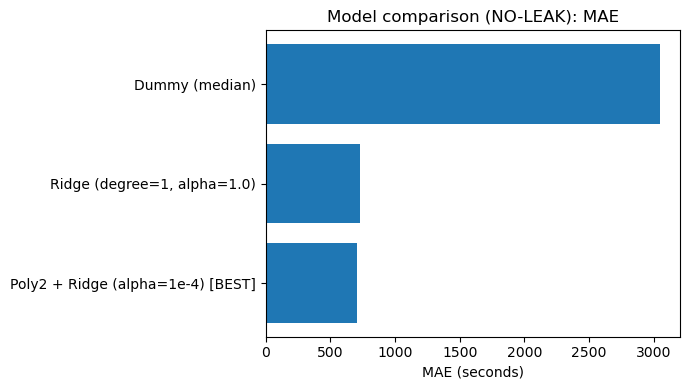

In [18]:
plt.figure(figsize=(7, 4))
plt.barh(results_final_df["model"], results_final_df["mae_mean"])
plt.title("Model comparison (NO-LEAK): MAE")
plt.xlabel("MAE (seconds)")
savefig("30_model_comparison_no_leak_mae_barh.png")
plt.show()
